### Setup


In [1]:
import six
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV

from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [2]:
import warnings
warnings.filterwarnings("ignore", "all")

np.set_printoptions(precision=2, suppress=False)

### Data Loading, Preprocessing


In [3]:
data = pd.read_csv("../data/responses.csv")
data


,text,label
0,I'm having insomnia.,insomnia
1,I can't seem to fall asleep.,insomnia
2,I'm struggling to get some shut-eye.,insomnia
3,I'm tossing and turning at night.,insomnia
4,Sleep eludes me.,insomnia
...,...,...
235,I feel like I'm in a constant state of agitation.,anxiety
236,I have trouble with commitment due to anxiety.,anxiety
237,I feel like I'm always searching for safety.,anxiety
238,I feel like I'm constantly being reminded of m...,anxiety


In [4]:
nlp = spacy.load("en_core_web_sm")


def basic_filter(text):
    return [t.lemma_ if t.pos_ in ["AUX", "PART"] else t.text for t in nlp(text) if not t.is_punct and not t.is_space]


def show_report(estimator, encoder, test_data, labels):
    y_pred = estimator.predict(test_data)
    print(classification_report(labels, y_pred))
    ConfusionMatrixDisplay.from_predictions(
        labels, y_pred, display_labels=encoder.classes_, normalize="true")


In [5]:
encoder = LabelEncoder()
vectorizer = TfidfVectorizer(tokenizer=basic_filter)

data["tokenized_text"] = list(map(basic_filter, data["text"]))
data["encoded_label"] = encoder.fit_transform(data["label"].to_numpy())

X_train, X_test, y_train, y_test = train_test_split(data["text"].to_numpy(
), data["encoded_label"].to_numpy(), train_size=0.8, random_state=42)

X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

data

c:\tools\mambaforge\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,text,label,tokenized_text,encoded_label
0,I'm having insomnia.,insomnia,"[I, be, having, insomnia]",2
1,I can't seem to fall asleep.,insomnia,"[I, can, not, seem, to, fall, asleep]",2
2,I'm struggling to get some shut-eye.,insomnia,"[I, be, struggling, to, get, some, shut, eye]",2
3,I'm tossing and turning at night.,insomnia,"[I, be, tossing, and, turning, at, night]",2
4,Sleep eludes me.,insomnia,"[Sleep, eludes, me]",2
...,...,...,...,...
235,I feel like I'm in a constant state of agitation.,anxiety,"[I, feel, like, I, be, in, a, constant, state,...",0
236,I have trouble with commitment due to anxiety.,anxiety,"[I, have, trouble, with, commitment, due, to, ...",0
237,I feel like I'm always searching for safety.,anxiety,"[I, feel, like, I, be, always, searching, for,...",0
238,I feel like I'm constantly being reminded of m...,anxiety,"[I, feel, like, I, be, constantly, be, reminde...",0


              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.64      0.82      0.72        11
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        12

    accuracy                           0.85        48
   macro avg       0.86      0.85      0.85        48
weighted avg       0.86      0.85      0.85        48



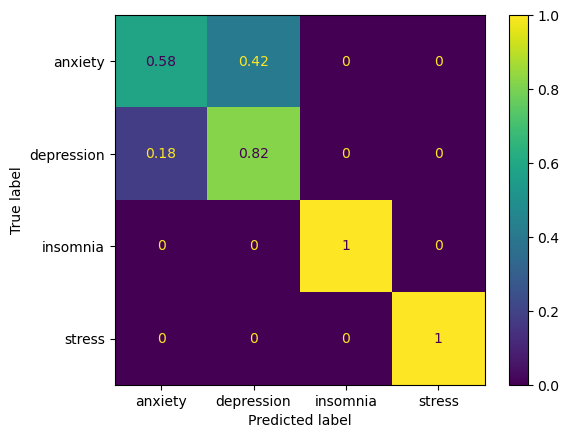

In [6]:
model = RidgeClassifierCV()
model.fit(X_train_vectorized, y_train)

show_report(model, encoder, X_test_vectorized, y_test)


In [7]:
# grid_params = {"n_estimators": list(range(1, 50))}
# model = GridSearchCV(RandomForestClassifier(random_state=1),
#                      param_grid=grid_params, scoring="f1_macro")
# model.fit(X_train_vectorized, y_train)

# model.best_estimator_

              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.69      0.82      0.75        11
           2       0.85      0.85      0.85        13
           3       0.86      1.00      0.92        12

    accuracy                           0.79        48
   macro avg       0.79      0.79      0.78        48
weighted avg       0.79      0.79      0.78        48



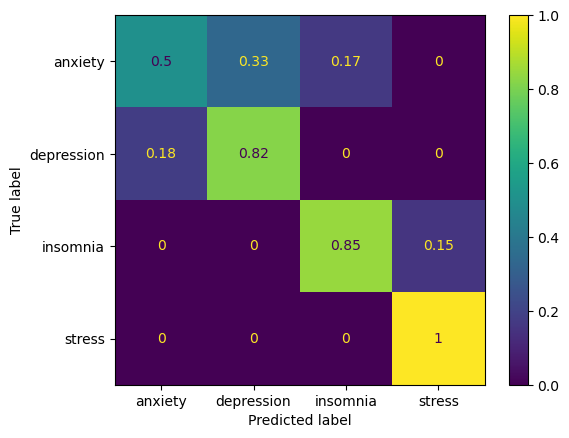

In [8]:
model = RandomForestClassifier() #(n_estimators=10, random_state=1)
model.fit(X_train_vectorized, y_train)

show_report(model, encoder, X_test_vectorized, y_test)

### Final Model


c:\tools\mambaforge\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.64      0.82      0.72        11
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        12

    accuracy                           0.85        48
   macro avg       0.86      0.85      0.85        48
weighted avg       0.86      0.85      0.85        48



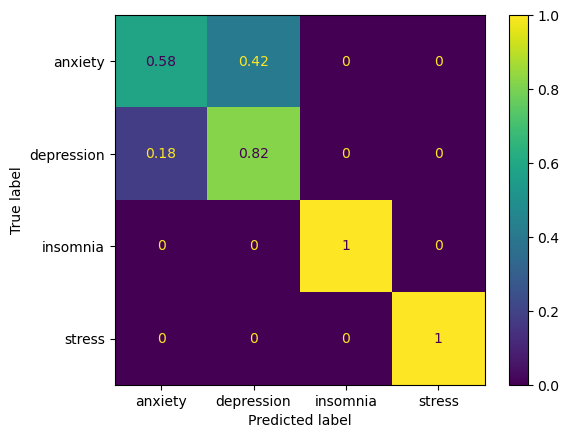

In [9]:
text_classifier = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=basic_filter)),
    ("classifier", RidgeClassifierCV()),
])

text_classifier.fit(X_train, y_train)
show_report(text_classifier, encoder, X_test, y_test)


In [10]:
import pickle
with open("model.pickle", "wb") as f:
    pickle.dump(text_classifier, f)

In [10]:
def get_label(text):
    labels = {0: 'anxiety', 1: 'depression', 2: 'insomnia', 3: 'stress'}
    pred = text_classifier.predict([text])
    return labels[pred[0]]